In [1]:
#getting the data
import torch
import torchvision
import requests
import zipfile
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
from PIL import Image



data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'


#if the image folder doesn't exist, download it and prepare it.
if image_path.is_dir():
  print(f'{image_path} directory already exists... skipping download')
else:
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents= True, exist_ok = True)

#download the data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print('downloading pizza, steak and sushi data...')
  f.write(request.content)

#unzipping the zip file
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip','r') as zip_ref:
  print('Unzipping pizza, steak and sushi data...')
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
downloading pizza, steak and sushi data...
Unzipping pizza, steak and sushi data...


In [2]:
#device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

#Data Augmentation


* It is the process of artificially adding diversity to the training data.

* It means artificially expand the size of a training dataset by creating modified versions of existing data. This process helps improve the generalization ability of models by introducing more variability into the training set.

augmentation doc:
https://pytorch.org/vision/0.13/transforms.html

illustrations of transform doc:
https://pytorch.org/vision/0.13/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

Implementing TrivialAugmentWide

alternative to more complex methods like AutoAugment and RandAugment, emphasizing simplicity and ease of use while still delivering competitive results.

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), #0-31, tells how intense you want the augmentation to be
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [5]:
image_path

PosixPath('data/pizza_steak_sushi')

In [6]:
#get all the image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/988559.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1230335.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1987407.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg')]

we want some random image path and run it through data_transform and then compare it with the original image



In [7]:
#write a transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),  #resize our image to 64x64
    transforms.RandomHorizontalFlip(p=0.5), #flip the images randomly on the horizontal
    transforms.ToTensor()
])

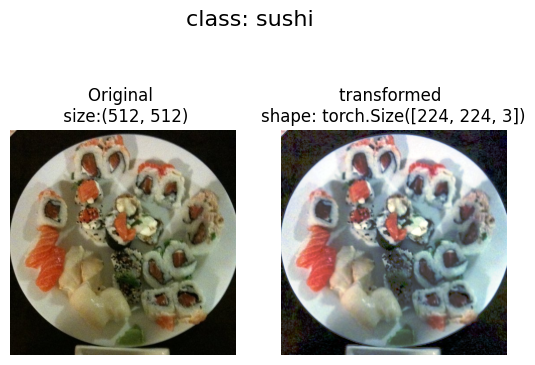

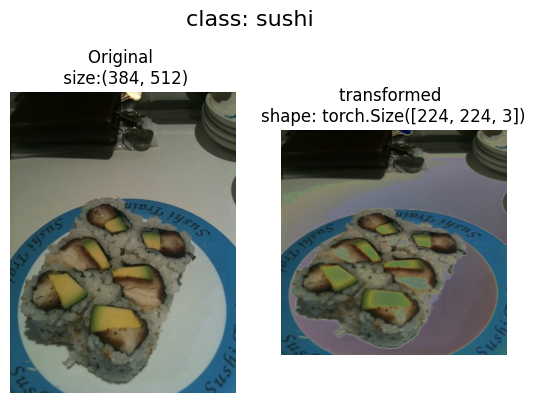

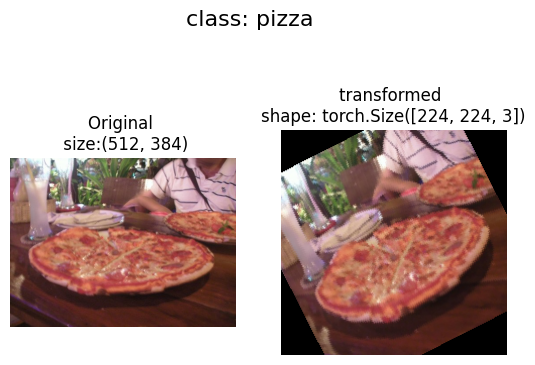

In [8]:
#plot the random transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):  #n --> number of images to transform
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols= 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original \n size:{f.size}')
      ax[0].axis(False)

      #transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) #c,h,w --> h,w,c
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'transformed \nshape: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths= image_path_list,
                        transform = train_transform,
                        n=3,
                        seed=0)


In [9]:
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None) #because we already had the data in three separate folders.

test_data = datasets.ImageFolder(root = test_dir,
                                  transform = data_transform,
                                  )

TrivialAugmentWide or trivial augment chooses randomly from the other augmentation types available and applies them at some random level of intensity from the range 0-31.

#1. Creating a baseline model (TinyVGG model) without data augmentation


* TinyVGG is a simplified version of the VGG (Visual Geometry Group) network, which is a deep convolutional neural network architecture


* VGG networks are known for their use of very small (3x3) convolution filters, which significantly improved the performance on image classification tasks when they were introduced

#1.1 Loading data and creating transforms

simple steps to setup or load the data:

1. create a simple transform
2. transform the data
3. turn the dataset into dataloader

In [10]:
#1. creating transforms

simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), #first we resize the images to 64x64
    transforms.ToTensor() #then we convert them to tensors of range 0-1
])

#2. loading the data using the ImageFolder
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root = train_dir,
                                  transform = simple_transform,
                                  target_transform = None)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                 transform = simple_transform)


#3. turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

#setup batch size and number of works
batch_size=32
num_workers = os.cpu_count()



#create dataloader's
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = batch_size,
                                     num_workers = num_workers,
                                     shuffle = True)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                     batch_size= batch_size,
                                     num_workers = num_workers,
                                    shuffle = False)



In [11]:
class_names = train_data_simple.classes
class_names

['pizza', 'steak', 'sushi']

#1.2 Building TinyVGGmodel class

In [12]:
from torch import nn

In [13]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) #default value is same as the kernel size
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) #default value is same as the kernel size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*13*13,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    #print(x.shape)
    x = self.conv_block2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
    #return self.Classifier(self.conv_block2(self.conv_block1(x))) #we can do this to make it faster

In [14]:
torch.manual_seed(42)
model0 = TinyVGG(input_shape=3,
                 hidden_units = 10,
                 output_shape=len(class_names)).to(device)
model0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [15]:
#get a single image
image_batch , label_batch = next(iter(train_dataloader_simple))
image_batch.shape , label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [16]:
#forward pass
model0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

#1.3 Model summary using Torchinfo

In [17]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [18]:
from torchinfo import summary
summary(model0 , input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

Torchinfo behind the scenes does a forward pass to the model with input sizes given.

Other than showing the changing shapes, the summary also tells us about:
1. the total parameters: where the model learnt some parameters in each of the layers such as weights or bias
2. model size: more layers, more parameters
3. estimated total size: tells about the storage.

#1.4 Training and Testing the model

train step func - takes in a model and dataloader and trains the model on the dataloader.

test step func - takes in a model and dataloader and evaluates the model on the dataloader

Remember: for training we want the model to learn so we want model.train, for testing we want to test the performance so we put it in eval mode

In [19]:
#create train and test loops functions

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  #put the model in train mode
  model.train()

  #setup the train loss and train accuracy values
  train_loss , train_acc = 0,0

  #loop through the data loader data batches
  for batch, (x,y) in enumerate(dataloader):
    x,y = x.to(device), y.to(device)

    #1. forward pass
    y_pred = model(x)

    #calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    #3. optimizer zero grad
    optimizer.zero_grad()

    #4. loss backwards
    loss.backward()

    #5. optimizer step
    optimizer.step()

    #calculate the accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) #using softmax here is optinal, it can be done with only argmax also
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  #adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss ,train_acc



In [20]:
#create a test step function

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  #put the model in eval mode
  model.eval()

  #setup test loss and test accuracy values
  test_loss , test_acc = 0,0

  #turn on the inference mode
  with torch.inference_mode():
    for batch , (x,y) in enumerate(dataloader):
      x,y = x.to(device) , y.to(device)

      #1. forward pass
      test_pred_logits = model(x)

      #calculate the loss
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      #calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  #adjust the metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

#1.5 create a train() function to combine train_step and test_step


In [21]:
import tqdm
from tqdm.auto import tqdm

#train func
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  #create an empty results dictionary
  results = {'train_loss': [],
             'train_acc':[],
             'test_loss':[],
             'test_acc':[]}

  #loop through training and testing step for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss , train_acc = train_step(model=model,
                                        dataloader = train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer)
                                        #device=device)

    test_loss , test_acc = test_step(model=model,
                                        dataloader = test_dataloader,
                                        loss_fn=loss_fn)
                                        #device=device)

    #print out everything
    print(f'Epoch: {epoch} | train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

    #update results dictionary
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  #return the filled results at the end of the epochs
  return results

#1.6 Train and evaluate the model0

In [22]:
torch.manual_seed(42)
num_epochs = 5

model0 = TinyVGG(input_shape = 3,
                 hidden_units = 10,
                 output_shape = len(train_data.classes)).to(device)

#setup the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model0.parameters(),
                             lr=0.001) #default value

#start the timer
from timeit import default_timer as timer
start_time = timer()

#train model
model0_results = train(model = model0,
                       train_dataloader = train_dataloader_simple,
                       test_dataloader = test_dataloader_simple,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = num_epochs)

#end the timer
end_time = timer()
print(f'total training time: {end_time - start_time:.3f} seconds')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924
Epoch: 3 | train loss: 1.0842 | Train acc: 0.3984 | Test loss: 1.0608 | Test acc: 0.5833
Epoch: 4 | train loss: 1.0662 | Train acc: 0.4141 | Test loss: 1.0654 | Test acc: 0.5644
total training time: 12.139 seconds


We can see that we have a test accuracy of only 56% , so we need to improve it.

In [23]:
model0_results


{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333137989044,
  1.0662163347005844],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608317852020264,
  1.065395991007487],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

#1.7 Plot the loss curves of the model0

A loss curve is a way of tracking the model's progress with time.


In [24]:
#get the model0 results keys
model0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [25]:
import typing
from typing import List , Dict

In [26]:
def plot_loss_curves(results: Dict[str , List[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  #setup a plot
  plt.figure(figsize=(15,7))

  #plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = 'train_loss')
  plt.plot(epochs, test_loss , label = 'test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs , accuracy , label='train_accuracy')
  plt.plot(epochs, test_accuracy , label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()

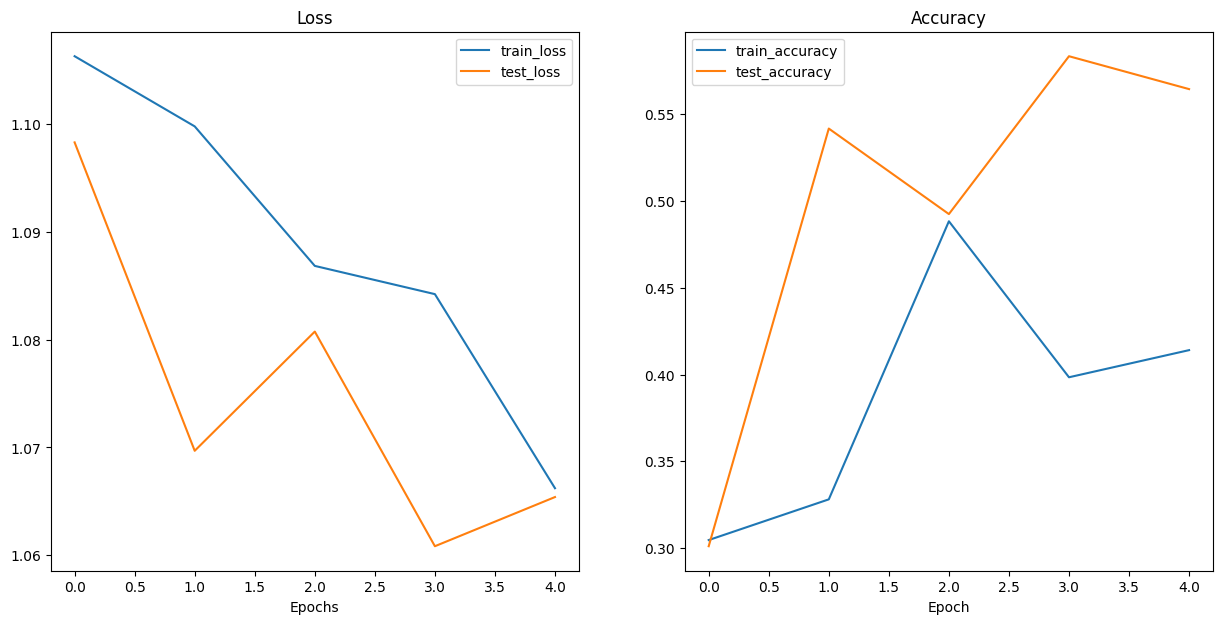

In [27]:
plot_loss_curves(model0_results)

It looks like our model is Underfitting

#Machine learning is all about the balance between Underfitting and Overfitting

#a. Overfitting

A model that performs exceptionally well on the training data but poorly on new, unseen data.

#Dealing with overfitting

1. get more data
2. data augmentation
3. better data - enhance quality
4. use transfer learning
5. simplify the model - reduce layers, take away complexity
6. use learning rate decay - to decay the learning rate over the span of time
7. use early stopping - save the patterns where the model's loss were the lowest.


#b. Underfitting

#Dealing with underfitting

1. add more layers/units
2. adjust the learning rate
3. train for longer or more epochs - gives the model more opprotunities to
learn
4. use transfer learning
5. use less regularization - preventing overfitting

#2. Creating a TinyVGG model with Data Augmentation

#2.1 create a training transform with Data Augmentation


In [28]:
from torchvision import transforms

train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])


test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])


#2.2 Create train and test datasets and dataloader with data augmentation

In [29]:
#turn the image into the datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_transform_trivial_augment)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = test_transform)


In [30]:
#turn our datasets into dataloader

import os
batch_size=32
num_workers = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                                        batch_size = batch_size,
                                        num_workers = num_workers,
                                        shuffle = True)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                        batch_size = batch_size,
                                        num_workers = num_workers,
                                        shuffle = True)
train_dataloader_augmented , test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7934d21d6f80>,
 <torch.utils.data.dataloader.DataLoader at 0x7934d21145e0>)

#2.3 Constructing and training model1

In [31]:
#create model1 and send it to the target device

torch.manual_seed(42)
model1 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data_augmented.classes)).to(device)

model1

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [32]:
torch.manual_seed(42)
num_epochs = 5

#loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(),
                             lr=0.001)

#start the timer
from timeit import default_timer as timer
start_time = timer()

model1_results = train(model = model1,
                       train_dataloader = train_dataloader_augmented,
                       test_dataloader = test_dataloader_simple,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = num_epochs)

end_time = timer()
print(f'total training time for model 1: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1017 | Test acc: 0.2604
Epoch: 1 | train loss: 1.0792 | Train acc: 0.4258 | Test loss: 1.1066 | Test acc: 0.3400
Epoch: 2 | train loss: 1.1276 | Train acc: 0.3047 | Test loss: 1.1021 | Test acc: 0.3598
Epoch: 3 | train loss: 1.0823 | Train acc: 0.4258 | Test loss: 1.0924 | Test acc: 0.3598
Epoch: 4 | train loss: 1.1020 | Train acc: 0.3047 | Test loss: 1.0924 | Test acc: 0.3400
total training time for model 1: 14.191 seconds


we see that we got better results without data augmentation

In [33]:
model1_results

{'train_loss': [1.1049142181873322,
  1.0792425721883774,
  1.1276408731937408,
  1.0822977051138878,
  1.1019537895917892],
 'train_acc': [0.25, 0.42578125, 0.3046875, 0.42578125, 0.3046875],
 'test_loss': [1.1016939878463745,
  1.1066132386525471,
  1.1021100680033367,
  1.0924052000045776,
  1.0923577149709065],
 'test_acc': [0.2604166666666667,
  0.33996212121212127,
  0.35984848484848486,
  0.35984848484848486,
  0.33996212121212127]}

#2.4 plotting the loss curves for the model

a loss curve helps you evaluate your model performance.

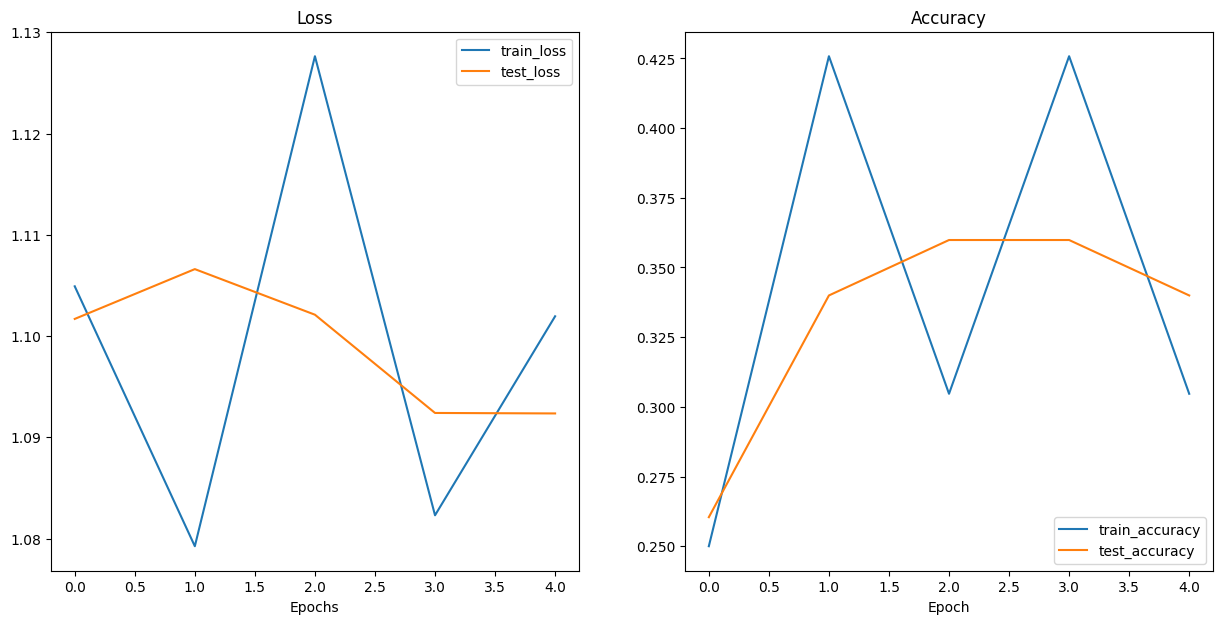

In [34]:
plot_loss_curves(model1_results)

Our model is overfitted

#3. Compare model0 and model1 results

After evaluating our modelling experiments on their own, its important to compare them to each other.

In [35]:
import pandas as pd
model0_df = pd.DataFrame(model0_results)
model1_df = pd.DataFrame(model1_results)

In [36]:
model0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069690,0.541667
2,1.086854,0.488281,1.080757,0.492424
3,1.084233,0.398438,1.060832,0.583333
4,1.066216,0.414062,1.065396,0.564394


In [37]:
model1_df

,train_loss,train_acc,test_loss,test_acc
0,1.104914,0.250000,1.101694,0.260417
1,1.079243,0.425781,1.106613,0.339962
2,1.127641,0.304688,1.102110,0.359848
3,1.082298,0.425781,1.092405,0.359848
4,1.101954,0.304688,1.092358,0.339962


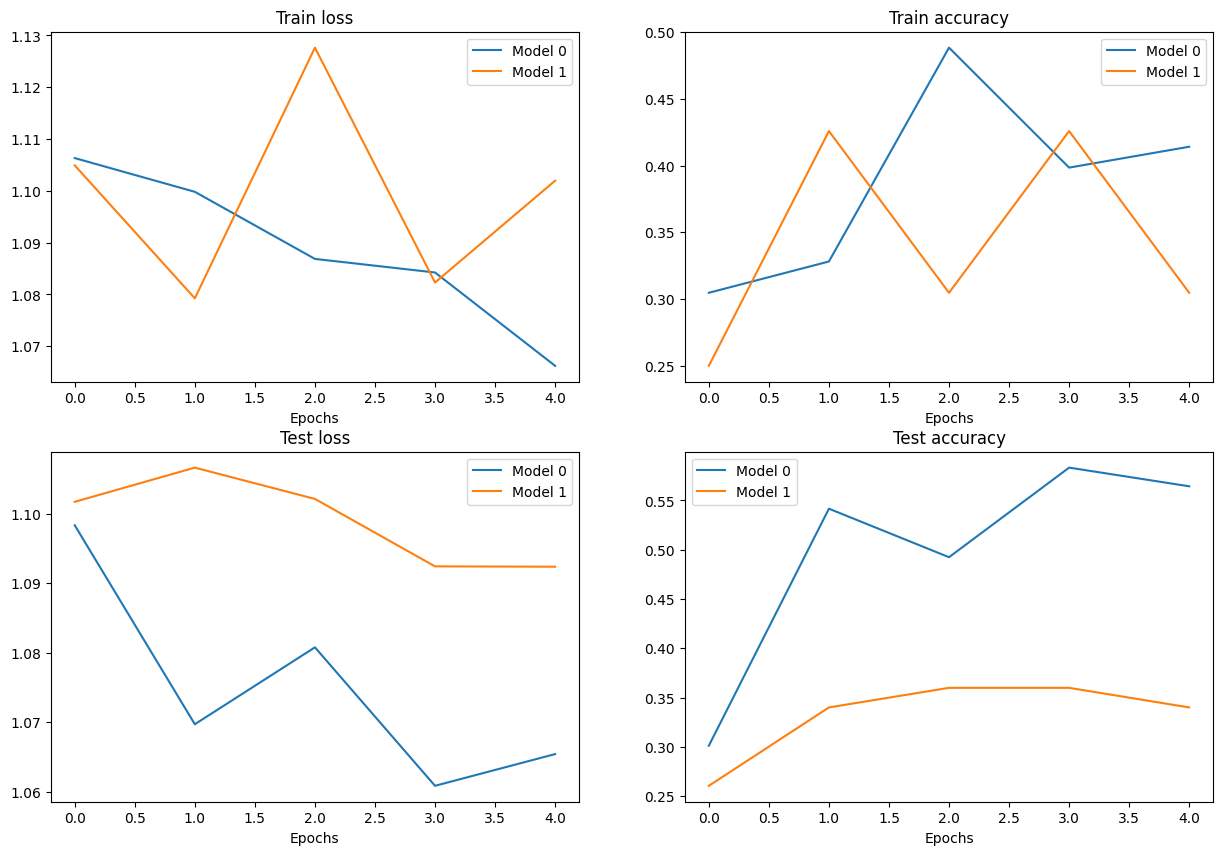

In [38]:
#setup a plot
plt.figure(figsize=(15,10))

epochs = range(len(model0_df))

#train loss
plt.subplot(2,2,1)
plt.plot(epochs, model0_df['train_loss'] , label='Model 0')
plt.plot(epochs, model1_df['train_loss'] , label='Model 1')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.legend()


#train accuracy
plt.subplot(2,2,2)
plt.plot(epochs, model0_df['train_acc'] , label='Model 0')
plt.plot(epochs, model1_df['train_acc'] , label='Model 1')
plt.title('Train accuracy')
plt.xlabel('Epochs')
plt.legend()



#train loss
plt.subplot(2,2,3)
plt.plot(epochs, model0_df['test_loss'] , label='Model 0')
plt.plot(epochs, model1_df['test_loss'] , label='Model 1')
plt.title('Test loss')
plt.xlabel('Epochs')
plt.legend()


#test loss
plt.subplot(2,2,4)
plt.plot(epochs, model0_df['test_acc'] , label='Model 0')
plt.plot(epochs, model1_df['test_acc'] , label='Model 1')
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.legend()

we see that model1 is overfitting , so we can say Data augmentation was not the right change to make.

Model0 is moving in the right direction.

#4. Making model predictions on our custom image dataset

we don't use images from the train set or the test set to make predictions.

In [39]:
#download custom image
import requests

#setup custom image path
custom_image_path = data_path / 'pizza-man.jpeg'

#download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path , 'wb') as f:
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exists, skipping download..')

we have to make sure our custom image is in the same form as the data our model was trained on.

* in tensor form with datatype torch.float32
* of shape 64x64x3
* on the right device

In [40]:
#loading in a custom image with pyTorch

import torchvision

#read in the custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f'custom image tensor\n: {custom_image_uint8}')
print(f'custom image shape: {custom_image_uint8.shape}')
print(f'custom image datatype: {custom_image_uint8.dtype}')


custom image tensor
: tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
custom image shape: torch.Size([3, 4032, 3024])
custom image data

our model was trained for images of shape 64x64 but this image has a much larger shape.

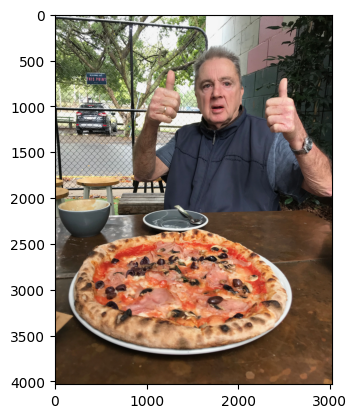

In [41]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [42]:
#load in image and convert to torch.float32

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

divide by 255 to scale these values b/w 0-1

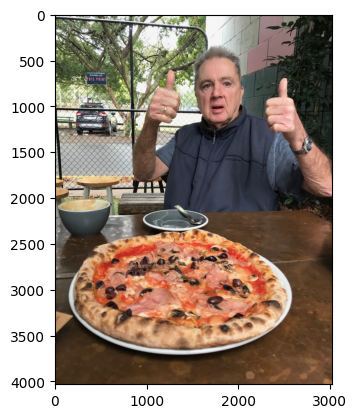

In [43]:
plt.imshow(custom_image.permute(1,2,0))

In [44]:
#we need to resize the image because it is still very large

custom_image_transform = transforms.Compose([
    transforms.Resize((64,64))
])

#transform target image
custom_image_transformed = custom_image_transform(custom_image)

print(f'original shape: {custom_image.shape}')
print(f'transformed shape: {custom_image_transformed.shape}')

original shape: torch.Size([3, 4032, 3024])
transformed shape: torch.Size([3, 64, 64])


got the perfect shape now

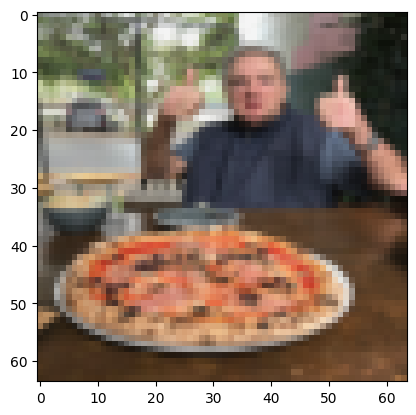

In [45]:
plt.imshow(custom_image_transformed.permute(1,2,0))

we see the change in image from high quality to low quality

In [46]:
model1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [47]:
model1.eval()
with torch.inference_mode():
  custom_image_pred = model1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0851, -0.0954, -0.1103]])

In [48]:
#convert logits to prediction labels

#logits -->prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3763, 0.3142, 0.3095]])

In [49]:
#convert the prediction probabilities to prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred , dim=1)
custom_image_pred_labels

tensor([0])

In [55]:
class_names[custom_image_pred_labels]

'pizza'

it gave the correct prediction......yayyy

In [56]:
#building a function for our prediction

def pred_and_plot_image(model: torch.nn.Module,
                        image_path:str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
  #load in the target
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  target_image = target_image / 255

  if transform:
    target_image = transform(target_image)

  model.to(device)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)

    target_image_pred = model(target_image.to(device))

  #logits -->probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  #probabilities --> labels
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  #plot the image with the prediction and the probabilities
  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title = f'pred {class_names[target_image_pred_labels.cpu()]} | prob: {target_image_pred_probs.max().cpu():.3f}'
  else:
    title = f'pred {target_image_pred_labels} | prob: {target_image_pred_probs.max().cpu():.3f}'
  plt.title(title)
  plt.axis(False)




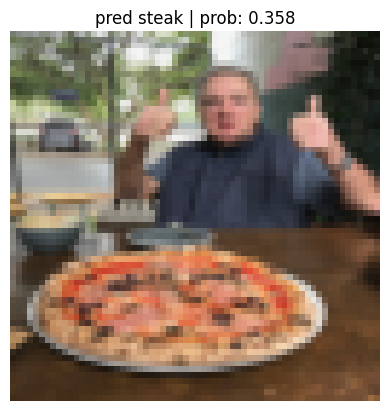

In [57]:
#pred on our custom image
pred_and_plot_image(model = model0,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device = device)